In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.qmdataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

from mlelec.models.equivariant_nonlinear_lightning import LitEquivariantNonlinearModel, MSELoss
from mlelec.models.equivariant_nonlinear_lightning import MLDatasetDataModule
from mlelec.callbacks.logging import LoggingCallback
from mlelec.callbacks.progress_bar import ProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl

Using PyTorch backend.


/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {14: [[1,0,0], [2,0,0], [3,0,0], [2,1,-1], [2,1,0], [2,1,1], [3,1,-1], [3,1,0], [3,1,1]]},
               # 6: [[1,0,0], [2,0,0], [2,1,-1], [2,1,0], [2,1,1]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthdzvp': {14: [[2,0,0], [3,0,0], [2,1,1], [2,1,-1], [2,1,0], [3,1,1], [3,1,-1], [3,1,0], [3,2,-2], [3,2,-1], [3,2,0], [3,2,1], [3,2,2]]},
    'gthszv':  {14: [[3,0,0], [3,1,1], [3,1,-1], [3,1,0]]}
}

In [4]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5
cutoff_atom = 6

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff_atom,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

# QMD

In [14]:
workdir = '/scratch/pegolo/silicon_deringer'
every = 5

For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [15]:
qmdata = QMDataset.from_file(frames_path = f'{workdir}/silicon_frames.xyz', 
                             fock_realspace_path = f'{workdir}/gthdzvp/real_focks.npy', 
                             overlap_realspace_path = f'{workdir}/gthdzvp/real_overlaps.npy',
                             dimension = 3, 
                             device = 'cpu', 
                             kmesh_path = f'{workdir}/kmesh.dat',
                             orbs_name='gthdzvp', 
                             orbs=orbitals['gthdzvp'], 
                             frame_slice = f'::{every}')

In [16]:
bas = 'sto-3g'
qmdata_sto3G = QMDataset.from_file(frames_path = f'{workdir}/silicon_frames.xyz', 
                                 fock_realspace_path = f'{workdir}/{bas}/real_focks.npy', 
                                 overlap_realspace_path = f'{workdir}/{bas}/real_overlaps.npy',
                                 dimension = 3, 
                                 device = 'cpu', 
                                 kmesh_path = f'{workdir}/kmesh.dat',
                                 orbs_name=bas, 
                                 orbs=orbitals[bas], 
                                 frame_slice = f'::{every}')

# MLD

In [111]:
from mlelec.data.mldataset import MLDataset
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_kspace', 'overlap_kspace', 'eigenvalues', 'atom_resolved_density'],
                   features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   train_frac = 0.5,
                   val_frac = 0.5,
                   test_frac = 0.0,
                   shuffle = False,
                   model_basis = orbitals['sto-3g'],
                   aux_overlap_kspace = qmdata_sto3G.overlap_kspace
                  )

# Model

Initialize the model

In [112]:
logger = TensorBoardLogger("tb_logs", name="silicon")

In [113]:
data_module = MLDatasetDataModule(mldata, batch_size=1)

model = LitEquivariantNonlinearModel(
    mldata=mldata,
    nhidden=4,
    nlayers=1,
    activation='ReLU',
    apply_norm=True,
    learning_rate=1e-3,
    loss_fn=MSELoss(),
    is_indirect = True,
    eigenvalues = True,
    atom_resolved_density = True
)

In [114]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=100,
    verbose=False,
    mode='min'
)

In [115]:
progress_bar = ProgressBar()
logger_callback = LoggingCallback(log_every_n_epochs = 1)

In [124]:
trainer = pl.Trainer(max_epochs=10000, 
                     accelerator='cpu', 
                     check_val_every_n_epoch=100,
                     callbacks=[early_stopping, progress_bar]
                     # callbacks=[early_stopping, logger_callback],
                     # enable_progress_bar=False
                    )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [125]:
trainer.fit(model, data_module)


  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | EquivariantNonlinearModel | 71.2 K | eval
-----------------------------------------------------------
71.2 K    Trainable params
0         Non-trainable params
71.2 K    Total params
0.285     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [96]:
batch.atom_resolved_density[0].shape

torch.Size([125, 16])

In [95]:
trainer.test(model, data_module)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


[]

In [56]:
from mlelec.data.derived_properties import compute_atom_resolved_density, compute_eigenvalues

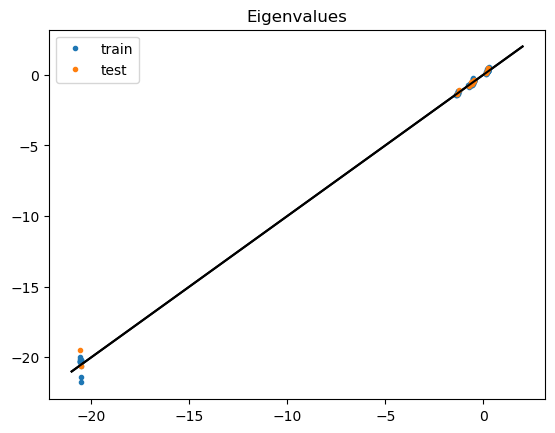

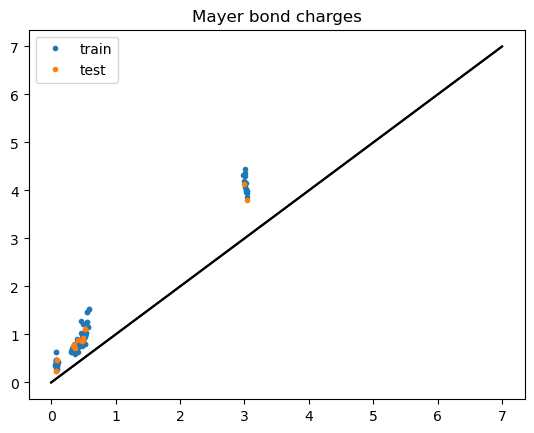

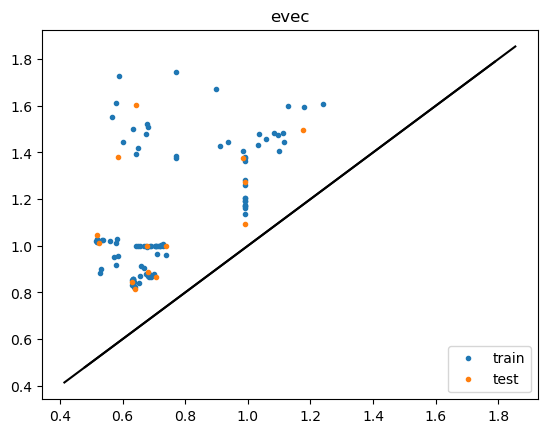

In [101]:
test_dl = DataLoader(mldata.test_dataset, batch_size = len(mldata.test_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()

data = {}
for dl_, lbl in zip([train_dl, test_dl], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    HT = blocks_to_matrix(pred, mldata.model_basis, mldata.structures, detach = True)
    HT = [HT[i][0,0,0] for i in batch.sample_id]


    pred_eigvals, pred_eigvec = compute_eigenvalues(HT, batch.overlap_realspace, return_eigenvectors=True)
    pred_ard, _ = compute_atom_resolved_density(pred_eigvec, 
                                             [mldata.qmdata.structures[i] for i in batch.sample_id], 
                                             mldata.model_basis, 
                                             mldata.qmdata.ncore)
    # pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata, batch, HT, device, overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

    small_shapes = [p.shape for p in pred_eigvals]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([batch.eigenvalues[i][s].flatten() for i, s in enumerate(slices)])
    y = torch.cat([p.flatten() for p in pred_eigvals])
    ax_e.plot(x, y, '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    x = torch.cat([ard.flatten() for ard in batch.atom_resolved_density])
    y = torch.cat([ard.flatten() for ard in pred_ard])
    ax_a.plot(x, y, '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

    small_shapes = [p.shape for p in pred_eigvec]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([torch.norm(batch.eigenvectors[i][s], dim = (0)).flatten() for i, s in enumerate(slices)])
    y = torch.cat([torch.norm(p, dim = (0)).flatten() for p in pred_eigvec])
    # pred_evn, targ_evn = torch.norm(pred_eigvec, dim = (1)), torch.norm(batch.eigenvectors[slices], dim = (1))
    
    ax_evec.plot(x, y, '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [97]:
# N. of eigenvalues to match (this needs to be adapted for diverse datasets
n_eig_to_match = 5
dl = mts.learn.DataLoader(mldata.train_dataset, batch_size = 2, collate_fn=mldata.group_and_join)

In [ ]:
nepoch = 1000
nevery = 10
losses = []
losses_e = []
losses_ard = []
losses_evec = []

for epoch in range(nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_evec = 0
    epoch_loss_ard = 0
    eig_sum = 0
    

    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)

        loss = L2_loss(pred,)
        # HT = blocks_to_matrix(pred, qmdata_sto3G, detach = False)
        # HT = [HT[i][0,0,0] for i in batch.sample_id] # Required for now

        # pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

        # loss_e = Eigval_loss(pred_eigvals[:, :n_eig_to_match], batch.eigenvalues[:, :n_eig_to_match])
        
        # loss_ard = torch.sum((pred_ard - batch.atom_resolved_density)**2)
        
        # pred_ev_0 = torch.norm(pred_C[:, :, :n_eig_to_match], dim = (1))
        # targ_ev_0 = torch.norm(batch.eigenvectors[:, :, :n_eig_to_match], dim = (1))
        # loss_evec = torch.sum((pred_ev_0 - targ_ev_0)**2)
        
        # loss = loss_ard + loss_e + loss_evec
        
        loss.backward()
        optimizer.step()

        epoch_loss_e += loss_e.item()
        epoch_loss_evec += loss_evec.item()
        epoch_loss_ard += loss_ard.item()
        epoch_loss += loss.item()
        
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_e.append(epoch_loss_e)
    losses_evec.append(epoch_loss_evec)
    losses_ard.append(epoch_loss_ard)
    
    if epoch % nevery == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}; rmse_eig={np.sqrt(epoch_loss_e/5/160):>12.10f} rmse_evec={np.sqrt(epoch_loss_evec/5/160):>12.10f} rmse_ard={np.sqrt(epoch_loss_ard/160/9):>12.10f} ")

In [ ]:
mldata.model_basis

In [ ]:
pred = model.forward(batch.features, mldata.model_metadata)
HT = blocks_to_matrix(pred, qmdata_sto3G, detach = False)
HT = [HT[i][0,0,0] for i in batch.sample_id] # Required for now

pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

In [ ]:
model_old(batch.features, mldata.model_metadata)

In [ ]:
pred

In [ ]:
batch.fock_blocks

In [ ]:
print(batch.atom_resolved_density.shape)
print(pred_ard.shape)

In [ ]:
test_dl = DataLoader(mldata.test_dataset, batch_size = len(mldata.test_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()

data = {}
for dl_, lbl in zip([train_dl, test_dl], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    HT = blocks_to_matrix(pred, qmdata, detach = True)
    HT = [HT[i][0,0,0] for i in batch.sample_id]
    
    pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata, batch, HT, device, overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

    ax_e.plot(batch.eigenvalues[:,:n_eig_to_match].flatten(), pred_eigvals[:,:n_eig_to_match].detach().flatten(), '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    ax_a.plot(batch.atom_resolved_density.flatten(), pred_ard.detach().flatten(), '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

    pred_evn, targ_evn = torch.norm(pred_eigvec[:, :, :n_eig_to_match], dim = (1)), torch.norm(batch.eigenvectors[:, :, :n_eig_to_match], dim = (1))
    
    ax_evec.plot(targ_evn.flatten(), pred_evn.detach().flatten(), '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [ ]:
batch = next(iter(test_dl))
print(batch.sample_id)
dl_frames = [qmdata.structures[A] for A in batch.sample_id]

pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata, detach = True)
HT = [HT[i][0,0,0] for i in batch.sample_id]

fock_predictions = torch.stack(HT)

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    qmdata_sto3G.basis,
)

fock_targets = unfix_orbital_order(
    batch.fock_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

fock_sto3g = unfix_orbital_order(
    qmdata_sto3G.fock_realspace,
    dl_frames,
    qmdata_sto3G.basis,
)

over_large = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_small = unfix_orbital_order(
    torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata_sto3G.basis,
)

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_large,
        qmdata.basis_name
    )

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_small,
        qmdata_sto3G.basis_name
    )

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_small,
        qmdata_sto3G.basis_name
    )

In [ ]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
ax.text(0.6, 0.25, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')